
## Otimização por colônia de formigas aplicado ao problema do caixeiro viajante
### Ant Colony Optimization for Traveling Salesman Problem
Baseado no código desenvolvido por [Marcos Castro de Souza (GitHub)](https://github.com/marcoscastro/tsp_aco)

In [1]:
# encoding:utf-8

import random, math
import matplotlib.pyplot as plt



## Classe que representa uma aresta


In [2]:
class Aresta:

	def __init__(self, origem, destino, custo):
		self.origem = origem
		self.destino = destino
		self.custo = custo
		self.feromonio = None

	def obterOrigem(self):
		return self.origem

	def obterDestino(self):
		return self.destino

	def obterCusto(self):
		return self.custo

	def obterFeronomio(self):
		return self.feromonio

	def setFeromonio(self, feromonio):
		self.feromonio = feromonio

## Classe que representa um grafo (grafos completos)


In [3]:
class Grafo:

	def __init__(self, num_vertices):
		self.num_vertices = num_vertices # número de vértices do grafo
		self.arestas = {} # dicionário com as arestas
		self.vizinhos = {} # dicionário com todos os vizinhos de cada vértice


	def adicionarAresta(self, origem, destino, custo):
		aresta = Aresta(origem=origem, destino=destino, custo=custo)
		self.arestas[(origem, destino)] = aresta
		if origem not in self.vizinhos:
			self.vizinhos[origem] = [destino]
		else:
			self.vizinhos[origem].append(destino)

	def obterCustoAresta(self, origem, destino):
		return self.arestas[(origem, destino)].obterCusto()

	def obterFeromonioAresta(self, origem, destino):
		return self.arestas[(origem, destino)].obterFeronomio()

	def setFeromonioAresta(self, origem, destino, feromonio):
		self.arestas[(origem, destino)].setFeromonio(feromonio)

	def obterCustoCaminho(self, caminho):
		custo = 0
		for i in range(self.num_vertices - 1):
			custo += self.obterCustoAresta(caminho[i], caminho[i+1])
		# adiciona o último custo
		custo += self.obterCustoAresta(caminho[-1], caminho[0])
		return custo


In [4]:
class GrafoCompleto(Grafo):
	# gera um grafo completo
	def gerar(self):
		for i in range(1, self.num_vertices + 1):
			for j in range(1, self.num_vertices + 1):
				if i != j:
					peso = random.randint(1, 10)
					self.adicionarAresta(i, j, peso)


## Classe que representa uma formiga

In [5]:
class Formiga:

	def __init__(self, cidade):
		self.cidade = cidade
		self.solucao = []
		self.custo = None

	def obterCidade(self):
		return self.cidade

	def setCidade(self, cidade):
		self.cidade = cidade

	def obterSolucao(self):
		return self.solucao

	def setSolucao(self, solucao, custo):
		# atualiza a solução
		if not self.custo:
			self.solucao = solucao[:]
			self.custo = custo
		else:
			if custo < self.custo:
				self.solucao = solucao[:]
				self.custo = custo

	def obterCustoSolucao(self):
		return self.custo



## Classe do ACO

In [6]:

class ACO:

	def __init__(self, grafo, num_formigas, alfa=1.0, beta=5.0, 
						iteracoes=10, evaporacao=0.5):
		self.grafo = grafo
		self.num_formigas = num_formigas
		self.alfa = alfa # importância do feromônio
		self.beta = beta # importância da informação heurística
		self.iteracoes = iteracoes # quantidade de iterações
		self.evaporacao = evaporacao # taxa de evaporação
		self.formigas = [] # lista de formigas

		lista_cidades = [cidade for cidade in range(1, self.grafo.num_vertices + 1)]
		# cria as formigas colocando cada uma em uma cidade
		for k in range(self.num_formigas):
			cidade_formiga = random.choice(lista_cidades)
			lista_cidades.remove(cidade_formiga)
			self.formigas.append(Formiga(cidade=cidade_formiga))
			if not lista_cidades:
				lista_cidades = [cidade for cidade in range(1, self.grafo.num_vertices + 1)]


		# calcula o custo guloso pra usar na inicialização do feromônio
		custo_guloso = 0.0 # custo guloso
		vertice_inicial = random.randint(1, grafo.num_vertices) # seleciona um vértice aleatório
		vertice_corrente = vertice_inicial
		visitados = [vertice_corrente] # lista de visitados
		while True:
			vizinhos = self.grafo.vizinhos[vertice_corrente][:]
			custos, escolhidos = [], {}
			for vizinho in vizinhos:
				if vizinho not in visitados:
					custo = self.grafo.obterCustoAresta(vertice_corrente, vizinho)
					escolhidos[custo] = vizinho
					custos.append(custo)
			if len(visitados) == self.grafo.num_vertices:
				break
			min_custo = min(custos) # pega o menor custo da lista
			custo_guloso += min_custo # adiciona o custo ao total
			vertice_corrente = escolhidos[min_custo] # atualiza o vértice corrente
			visitados.append(vertice_corrente) # marca o vértice corrente como visitado

		# adiciona o custo do último visitado ao custo_guloso
		custo_guloso += self.grafo.obterCustoAresta(visitados[-1], vertice_inicial)

		# inicializa o feromônio de todas as arestas
		for chave_aresta in self.grafo.arestas:
			feromonio = 1.0 / (self.grafo.num_vertices * custo_guloso)
			self.grafo.setFeromonioAresta(chave_aresta[0], chave_aresta[1], feromonio)


	def rodar(self):
		for it in range(self.iteracoes):

			# lista de listas com as cidades visitadas por cada formiga
			cidades_visitadas = []
			for k in range(self.num_formigas):
				# adiciona a cidade de origem de cada formiga
				cidades = [self.formigas[k].obterCidade()]
				cidades_visitadas.append(cidades)

			# para cada formiga constrói uma solução
			for k in range(self.num_formigas):
				for i in range(1, self.grafo.num_vertices):
					# obtém todos os vizinhos que não foram visitados
					cidades_nao_visitadas = list(set(self.grafo.vizinhos[self.formigas[k].obterCidade()]) - set(cidades_visitadas[k]))
					
					# somatório do conjunto de cidades não visitadas pela formiga "k"
					# servirá para utilizar no cálculo da probabilidade
					somatorio = 0.0
					for cidade in cidades_nao_visitadas:
						# calcula o feromônio
						feromonio =  self.grafo.obterFeromonioAresta(self.formigas[k].obterCidade(), cidade)
						# obtém a distância
						distancia = self.grafo.obterCustoAresta(self.formigas[k].obterCidade(), cidade)
						# adiciona no somatório
						somatorio += (math.pow(feromonio, self.alfa) * math.pow(1.0 / distancia, self.beta))

					# probabilidades de escolher um caminho
					probabilidades = {}

					for cidade in cidades_nao_visitadas:
						# calcula o feromônio
						feromonio = self.grafo.obterFeromonioAresta(self.formigas[k].obterCidade(), cidade)
						# obtém a distância
						distancia = self.grafo.obterCustoAresta(self.formigas[k].obterCidade(), cidade)
						# obtém a probabilidade
						probabilidade = (math.pow(feromonio, self.alfa) * math.pow(1.0 / distancia, self.beta)) / (somatorio if somatorio > 0 else 1)
						# adiciona na lista de probabilidades
						probabilidades[cidade] = probabilidade

					# obtém a cidade escolhida
					cidade_escolhida = max(probabilidades, key=probabilidades.get)

					# adiciona a cidade escolhida a lista de cidades visitadas pela formiga "k"
					cidades_visitadas[k].append(cidade_escolhida)

				# atualiza a solução encontrada pela formiga
				self.formigas[k].setSolucao(cidades_visitadas[k], self.grafo.obterCustoCaminho(cidades_visitadas[k]))

			# atualiza quantidade de feromônio
			for aresta in self.grafo.arestas:
				# somatório dos feromônios da aresta
				somatorio_feromonio = 0.0
				# para cada formiga "k"
				for k in range(self.num_formigas):
					arestas_formiga = []
					# gera todas as arestas percorridas da formiga "k"
					for j in range(self.grafo.num_vertices - 1):
						arestas_formiga.append((cidades_visitadas[k][j], cidades_visitadas[k][j+1]))
					# adiciona a última aresta
					arestas_formiga.append((cidades_visitadas[k][-1], cidades_visitadas[k][0]))
					# verifica se a aresta faz parte do caminho da formiga "k"
					if aresta in arestas_formiga:
						somatorio_feromonio += (1.0 / self.grafo.obterCustoCaminho(cidades_visitadas[k]))
				# calcula o novo feromônio
				novo_feromonio = (1.0 - self.evaporacao) * self.grafo.obterFeromonioAresta(aresta[0], aresta[1]) + somatorio_feromonio
				# seta o novo feromônio da aresta
				self.grafo.setFeromonioAresta(aresta[0], aresta[1], novo_feromonio)


		# percorre para obter as soluções das formigas
		solucao, custo = None, None
		for k in range(self.num_formigas):
			if not solucao:
				solucao = self.formigas[k].obterSolucao()[:]
				custo = self.formigas[k].obterCustoSolucao()
			else:
				aux_custo = self.formigas[k].obterCustoSolucao()
				if aux_custo < custo:
					solucao = self.formigas[k].obterSolucao()[:]
					custo = aux_custo
		#print(f'Solução final: it: {it} | {" -> ".join(str(i) for i in solucao)} | custo: {custo}\n')
		return custo

## Cria um grafo passando o número de vértices

In [7]:
grafo = Grafo(num_vertices=8)

# mapeando cidades para números
d = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8}
# adiciona as arestas
grafo.adicionarAresta(d['B'], d['A'], 42)
grafo.adicionarAresta(d['A'], d['B'], 42)
grafo.adicionarAresta(d['C'], d['A'], 61)
grafo.adicionarAresta(d['A'], d['C'], 61)
grafo.adicionarAresta(d['C'], d['B'], 14)
grafo.adicionarAresta(d['B'], d['C'], 14)
grafo.adicionarAresta(d['D'], d['A'], 30)
grafo.adicionarAresta(d['A'], d['D'], 30)
grafo.adicionarAresta(d['D'], d['B'], 87)
grafo.adicionarAresta(d['B'], d['D'], 87)
grafo.adicionarAresta(d['D'], d['C'], 20)
grafo.adicionarAresta(d['C'], d['D'], 20)
grafo.adicionarAresta(d['E'], d['A'], 17)
grafo.adicionarAresta(d['A'], d['E'], 17)
grafo.adicionarAresta(d['E'], d['B'], 28)
grafo.adicionarAresta(d['B'], d['E'], 28)
grafo.adicionarAresta(d['E'], d['C'], 81)
grafo.adicionarAresta(d['C'], d['E'], 81)
grafo.adicionarAresta(d['E'], d['D'], 34)
grafo.adicionarAresta(d['D'], d['E'], 34)
grafo.adicionarAresta(d['F'], d['A'], 82)
grafo.adicionarAresta(d['A'], d['F'], 82)
grafo.adicionarAresta(d['F'], d['B'], 70)
grafo.adicionarAresta(d['B'], d['F'], 70)
grafo.adicionarAresta(d['F'], d['C'], 21)
grafo.adicionarAresta(d['C'], d['F'], 21)
grafo.adicionarAresta(d['F'], d['D'], 33)
grafo.adicionarAresta(d['D'], d['F'], 33)
grafo.adicionarAresta(d['F'], d['E'], 41)
grafo.adicionarAresta(d['E'], d['F'], 41)
grafo.adicionarAresta(d['G'], d['A'], 31)
grafo.adicionarAresta(d['A'], d['G'], 31)
grafo.adicionarAresta(d['G'], d['B'], 19)
grafo.adicionarAresta(d['B'], d['G'], 19)
grafo.adicionarAresta(d['G'], d['C'], 8)
grafo.adicionarAresta(d['C'], d['G'], 8)
grafo.adicionarAresta(d['G'], d['D'], 91)
grafo.adicionarAresta(d['D'], d['G'], 91)
grafo.adicionarAresta(d['G'], d['E'], 34)
grafo.adicionarAresta(d['E'], d['G'], 34)
grafo.adicionarAresta(d['G'], d['F'], 19)
grafo.adicionarAresta(d['F'], d['G'], 19)
grafo.adicionarAresta(d['H'], d['A'], 11)
grafo.adicionarAresta(d['A'], d['H'], 11)
grafo.adicionarAresta(d['H'], d['B'], 33)
grafo.adicionarAresta(d['B'], d['H'], 33)
grafo.adicionarAresta(d['H'], d['C'], 29)
grafo.adicionarAresta(d['C'], d['H'], 29)
grafo.adicionarAresta(d['H'], d['D'], 10)
grafo.adicionarAresta(d['D'], d['H'], 10)
grafo.adicionarAresta(d['H'], d['E'], 82)
grafo.adicionarAresta(d['E'], d['H'], 82)
grafo.adicionarAresta(d['H'], d['F'], 32)
grafo.adicionarAresta(d['F'], d['H'], 32)
grafo.adicionarAresta(d['H'], d['G'], 59)
grafo.adicionarAresta(d['G'], d['H'], 59)


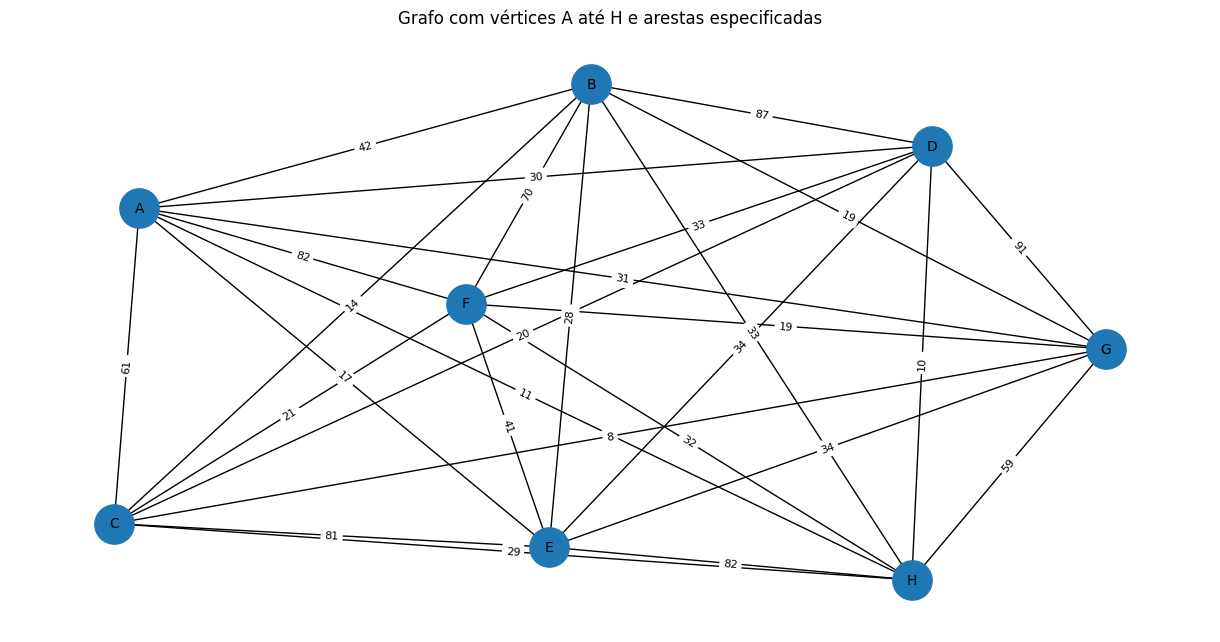

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Criando o grafo
G = nx.Graph()
plt.figure(figsize=(12, 6))  # Aumentando o tamanho da figura


edges = [
    ('A', 'B', 42), ('A', 'C', 61), ('A', 'D', 30), ('A', 'E', 17),
    ('A', 'F', 82), ('A', 'G', 31), ('A', 'H', 11),
    ('B', 'C', 14), ('B', 'D', 87), ('B', 'E', 28),
    ('B', 'F', 70), ('B', 'G', 19), ('B', 'H', 33),
    ('C', 'D', 20), ('C', 'E', 81), ('C', 'F', 21),
    ('C', 'G', 8), ('C', 'H', 29),
    ('D', 'E', 34), ('D', 'F', 33), ('D', 'G', 91),
    ('D', 'H', 10),
    ('E', 'F', 41), ('E', 'G', 34), ('E', 'H', 82),
    ('F', 'G', 19), ('F', 'H', 32),
    ('G', 'H', 59)
]

# Adicionando as arestas com os pesos
for u, v, weight in edges:
    G.add_edge(u, v, weight=weight)

# Plotando o grafo
pos = nx.spring_layout(G, seed=42)  # Posições dos vértices
nx.draw(G, pos, with_labels=True, node_size=800, font_size=10,font_color='black')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.title("Grafo com vértices A até H e arestas especificadas")
plt.show()


## Cria uma instância de ACO

In [40]:

aco = ACO(grafo=grafo, num_formigas=grafo.num_vertices, alfa=1.0, beta=5.0, 
			iteracoes=1000, evaporacao=0.5)
# roda o algoritmo
aco.rodar()

(999, 140)

In [51]:
max_iteracoes = 1000
resultados = []
for it in range(1, max_iteracoes+1):
    aco = ACO(grafo=grafo, num_formigas=grafo.num_vertices, alfa=1.0, beta=5.0, 
			iteracoes=it, evaporacao=0.5)
    resultados.append(aco.rodar())


<Figure size 2400x1000 with 0 Axes>

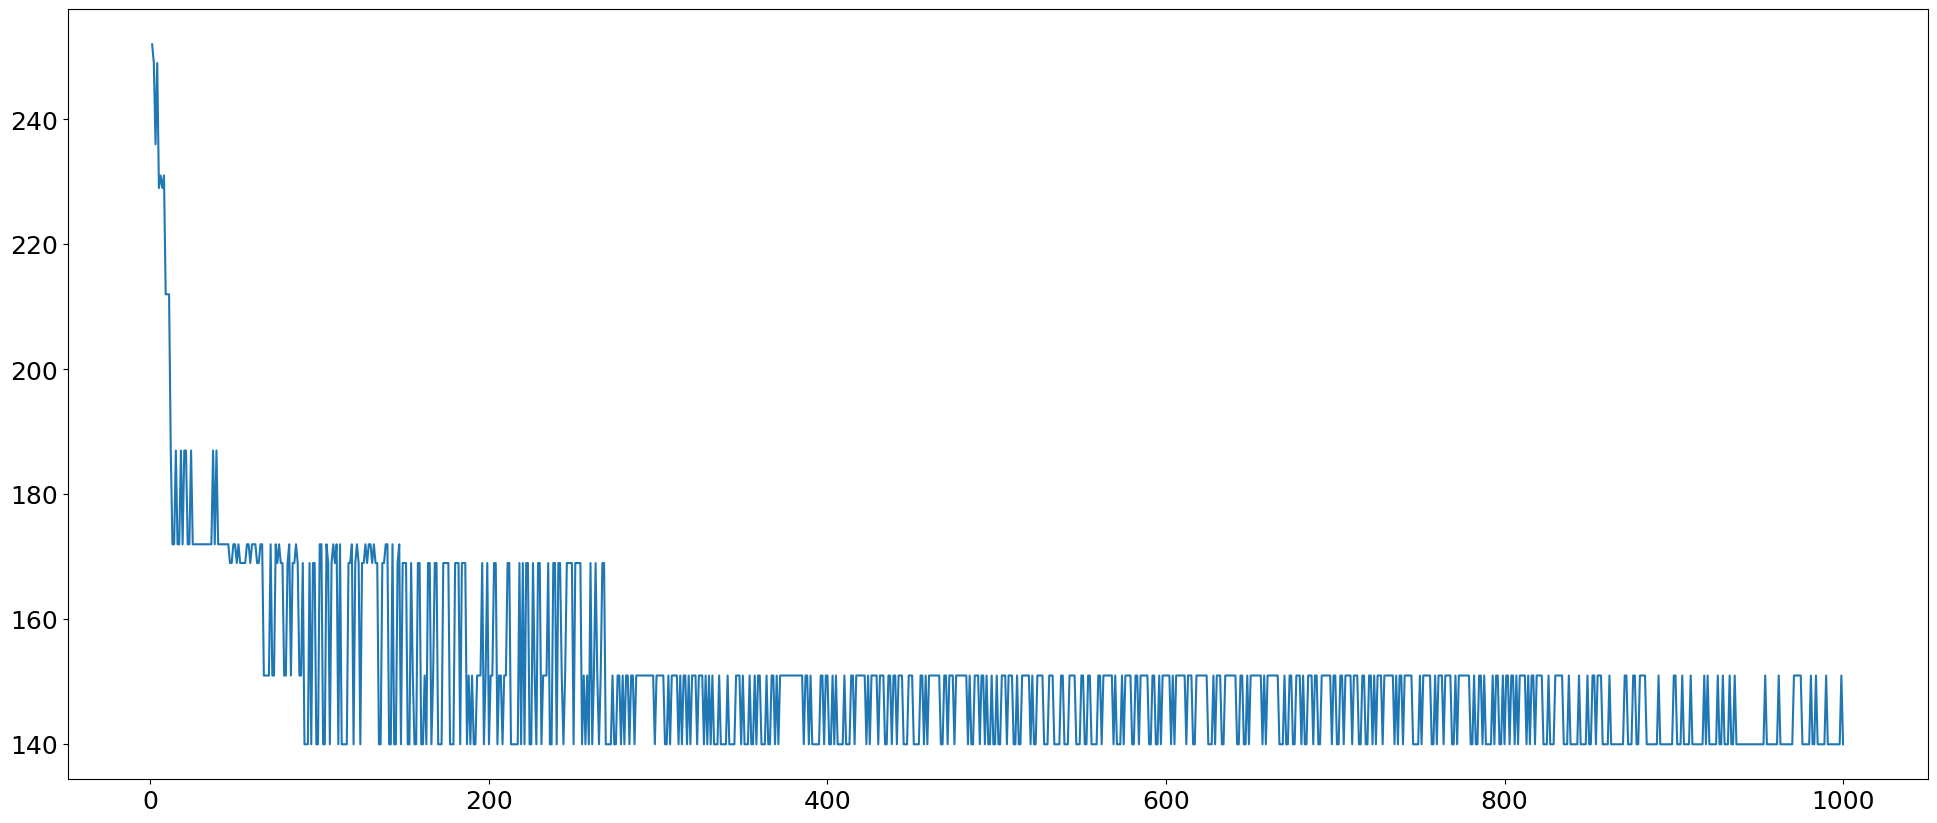

In [64]:
# plotando o gráfico
plt.figure(figsize=(24, 10))
plt.figure(figsize=(24, 10))
plt.plot([i[0] for i in resultados], [i[1] for i in resultados])
# plt.xlabel('Iterações', fontsize=16)
# plt.ylabel('Custo', fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [60]:
max_iteracoes = 1000
resultados = []
for it in range(1, max_iteracoes+1):
    aco = ACO(grafo=grafo, num_formigas=grafo.num_vertices, alfa=1.0, beta=5.0, iteracoes=it, evaporacao=0.5)
    resultados.append((it, aco.rodar()))

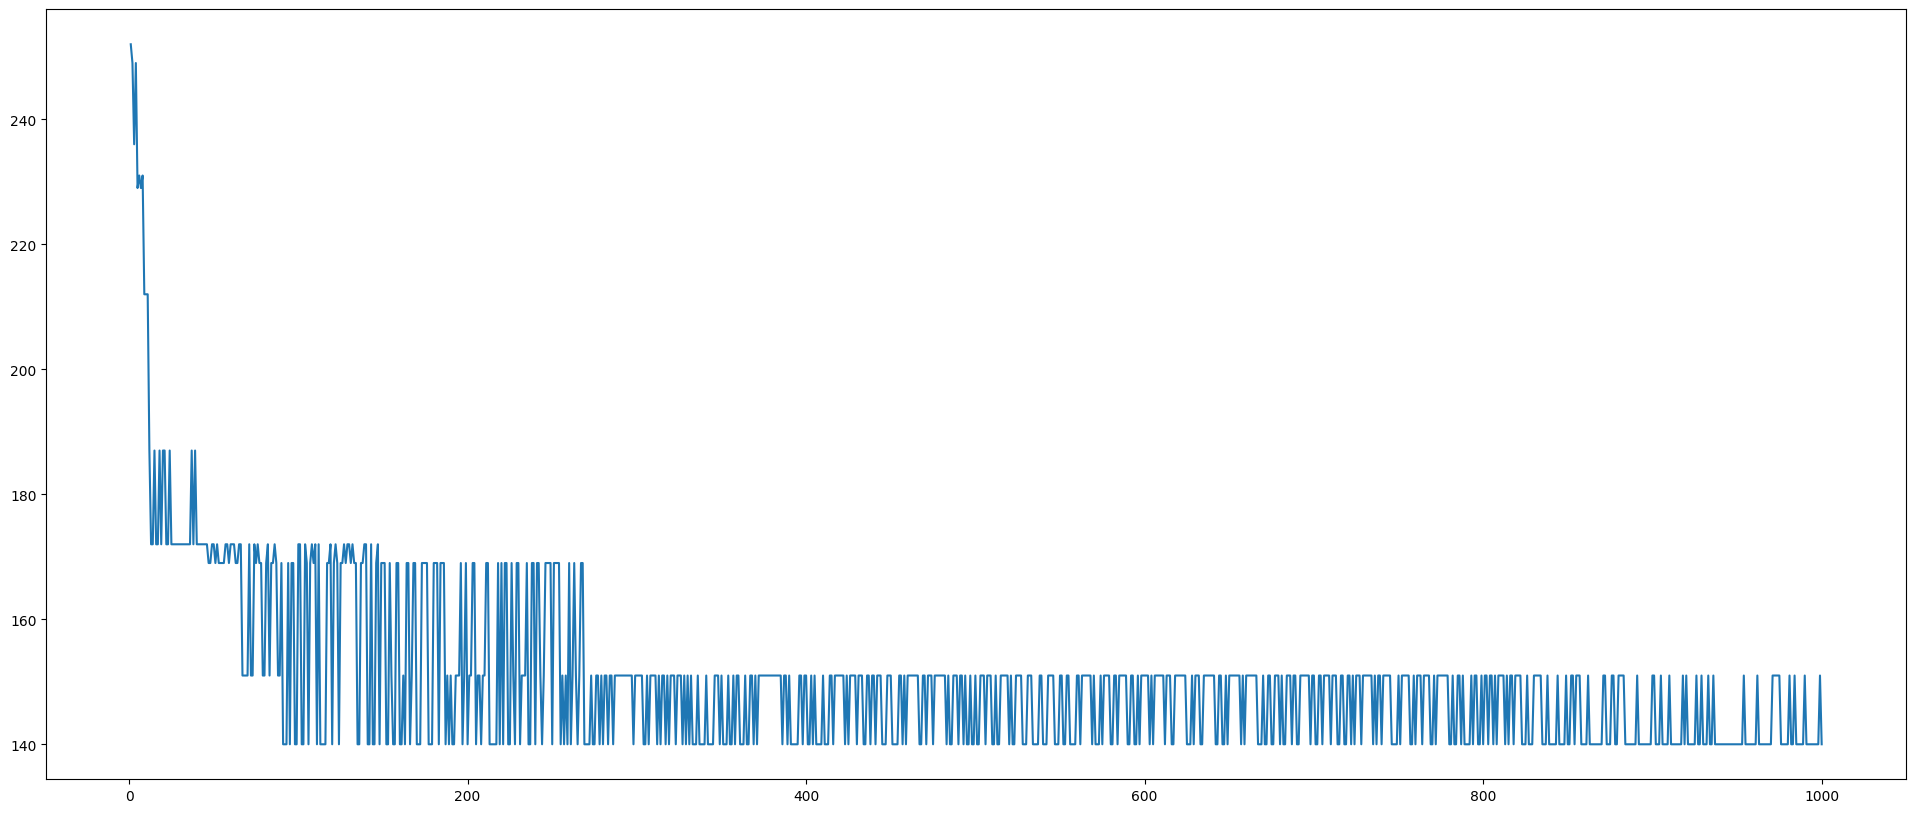

In [61]:
plt.figure(figsize=(24, 10))
plt.plot([i[0] for i in resultados], [i[1] for i in resultados],)

## Teste com grafo completo


In [13]:
num_vertices = 20
print('Teste de grafo com %d vertices...\n' % num_vertices)
grafo_completo = GrafoCompleto(num_vertices=num_vertices)
grafo_completo.gerar()
aco2 = ACO(grafo=grafo_completo, num_formigas=grafo_completo.num_vertices, 
			alfa=1, beta=5, iteracoes=100, evaporacao=0.5)
aco2.rodar()

Teste de grafo com 20 vertices...

Solução final: 13 -> 5 -> 7 -> 15 -> 17 -> 19 -> 9 -> 12 -> 16 -> 8 -> 2 -> 1 -> 10 -> 4 -> 11 -> 3 -> 14 -> 18 -> 6 -> 20 | custo: 71

